# Deep Learning Regression with Admissions Data

Creating a deep learning regression model that predicts the likelihood that a student applying to graduate school will be accepted based on various application factors (such as test scores).

This is a regression problem because the probability of being admitted is a continuous label between 0 and 1.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow	import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer

from scipy.stats import pearsonr

dataset_path = '/kaggle/input/graduate-admissions/Admission_Predict.csv'

# Data import and prepare

In [2]:
dataset = pd.read_csv(dataset_path)

**Data description**
* Serial No.: Index of each row (1-500)
* GRE Score: GRE test score (out of 340)
* TOEFL Score: TOEFL test score (out of 120)
* University Rating: Evaluated university rating (out of 5)
* SOP: Statement of Purpose Strength (out of 5)
* LOR: Letter of Recommendation Strength (out of 5)
* CGPA: Undergraduate GPA (out of 10)
* Research: Has research experience (either 0 or 1)
* Chance of Admit: Applicant’s chance of being admitted (ranging from 0 to 1)

In [3]:
dataset.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         400 non-null    int64  
 1   GRE Score          400 non-null    int64  
 2   TOEFL Score        400 non-null    int64  
 3   University Rating  400 non-null    int64  
 4   SOP                400 non-null    float64
 5   LOR                400 non-null    float64
 6   CGPA               400 non-null    float64
 7   Research           400 non-null    int64  
 8   Chance of Admit    400 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 28.2 KB


**Chance of admit** is value I want to predict so I save it as my labels

In [5]:
labels = dataset.iloc[:, -1]
labels.head(10)

0    0.92
1    0.76
2    0.72
3    0.80
4    0.65
5    0.90
6    0.75
7    0.68
8    0.50
9    0.45
Name: Chance of Admit , dtype: float64

**Other columns** will be used as features

In [6]:
features = dataset.iloc[:, 1: -1]
features.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,337,118,4,4.5,4.5,9.65,1
1,324,107,4,4.0,4.5,8.87,1
2,316,104,3,3.0,3.5,8.00,1
3,322,110,3,3.5,2.5,8.67,1
4,314,103,2,2.0,3.0,8.21,0


In [7]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.25, random_state=42)

GRE Score is out of 340, on the other hand univeristy rating is out of 5. Disproportion between features can cause problems when using regression learning model. Therefore I came up with **scaling** the data.

In [8]:
num_columns = features.columns
ct = ColumnTransformer([('transform', StandardScaler(), num_columns)], remainder='passthrough')
features_train_scale = ct.fit_transform(features_train)
features_test_scale = ct.transform(features_test)

In [9]:
print(features_train_scale)

[[-0.51832699 -0.57399919 -0.95044085 ...  0.05717854 -0.18943738
  -1.0762311 ]
 [-1.04994441  0.08703635  1.6654514  ... -0.4961622  -0.18943738
  -1.0762311 ]
 [ 0.01329044 -0.07822254 -0.07847677 ... -0.4961622   0.18445219
  -1.0762311 ]
 ...
 [-0.96134151 -0.4087403  -0.95044085 ... -0.4961622  -0.63130688
   0.92916847]
 [-1.31575313 -1.4002936  -1.82240493 ... -1.60284368 -2.27982
  -1.0762311 ]
 [-0.25251828 -0.24348142 -0.95044085 ...  0.05717854 -0.58032194
  -1.0762311 ]]


In [10]:
print(features_train_scale.shape[1])

7


In [17]:
print(features_train.shape[1])

7


Now data is **scaled and prepared** for training so now we have function for building our **model**.

In [18]:
def build_model(train_data, test_data, train_labels, test_labels, lr, batch_size):
    model = tf.keras.Sequential()
    model.add(InputLayer(input_shape=(7,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    
    model.summary()
    
    opt = Adam(learning_rate=lr)
    
    model.compile(loss='mse', metrics='mae', optimizer=opt)
    
    
    history = model.fit(train_data, train_labels, epochs=60, batch_size=batch_size, validation_split=0.25)  
    mmse, mmae = model.evaluate(test_data, test_labels)
    
    return model, history, mmse, mmae

Function for **plotting** parameters.

In [12]:
def plot_history(history):
    figs, axes = plt.subplots(1,2, figsize=(20,8))
    axes[0].plot(history.history['mae'])
    axes[0].plot(history.history['val_mae'])
    axes[0].set_title('MAE')
    axes[0].set_xlabel('Epochs')
    axes[0].legend(['train', 'validation'])

    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('MSE')
    axes[0].set_xlabel('Epochs')
    axes[1].legend(['train', 'validation'])
    plt.show()

My intention was to test different batch sizes and see which one is giving the best results, so I conducted multiple trainings in a loop.

############################################
ITERATION NR: 1
BATCH_SIZE: 2
OPTIMIZER LEARNING RATE: 0.01
############################################

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                256       
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
113/113 [==============================] - 1s 4ms/step - loss: 0.0648 - mae: 0.1798 - val_loss: 0.0462 - val_mae: 0.1727
Epoch 2/60
113/113 [==============================] - 0s 3ms/step - loss: 0.0157 - mae: 0.0974 - val_loss: 0.0113 - val_mae: 0.0815
Epoch 3/60
113/113 [=================

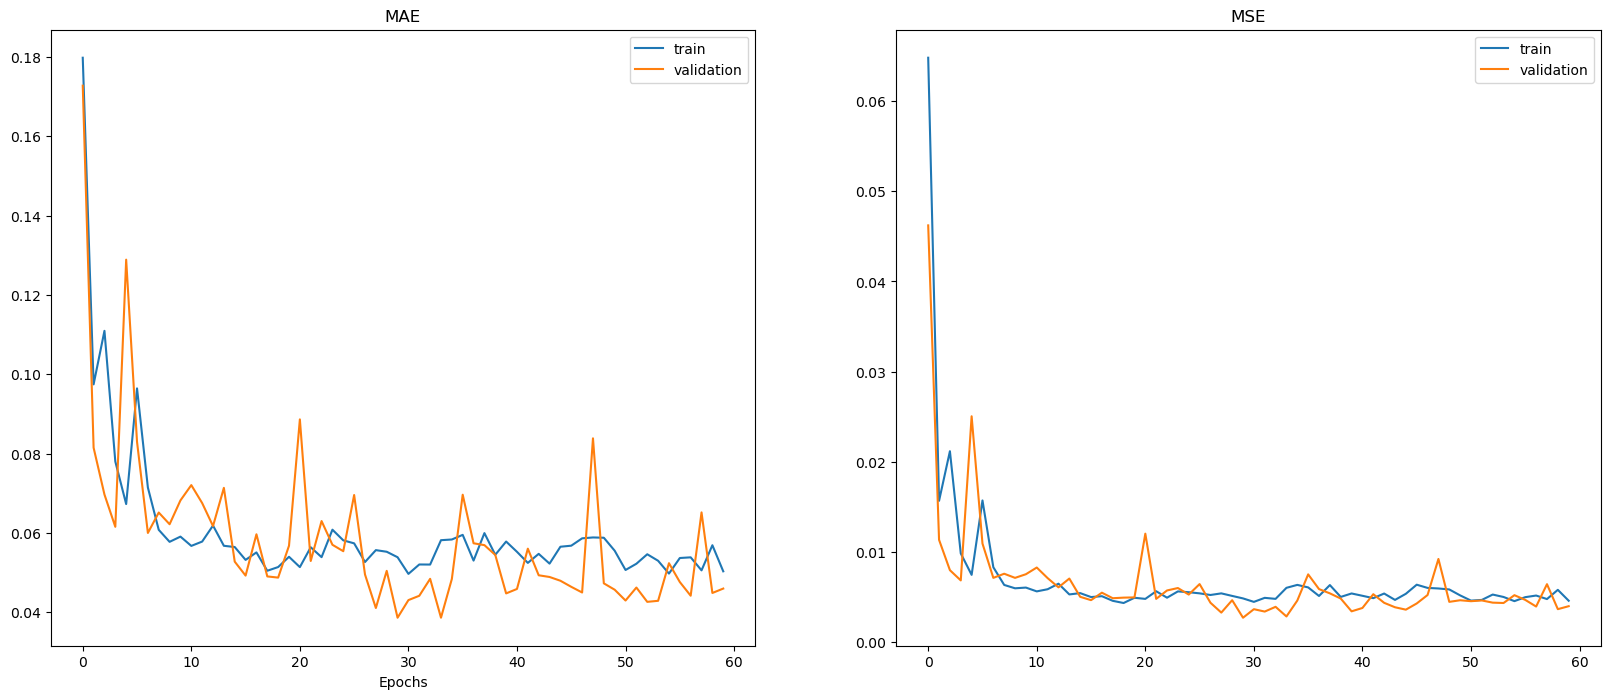

4/4 [==============================] - 0s 2ms/step
############################################
R^2 SCORE: 0.7970751939429527
PEARSONR: [0.9010447171084132]
MSE: 0.004790281876921654
MAE: 0.0530892051756382
############################################


############################################
ITERATION NR: 2
BATCH_SIZE: 4
OPTIMIZER LEARNING RATE: 0.01
############################################

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 32)                256       
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
57/57 [=============================

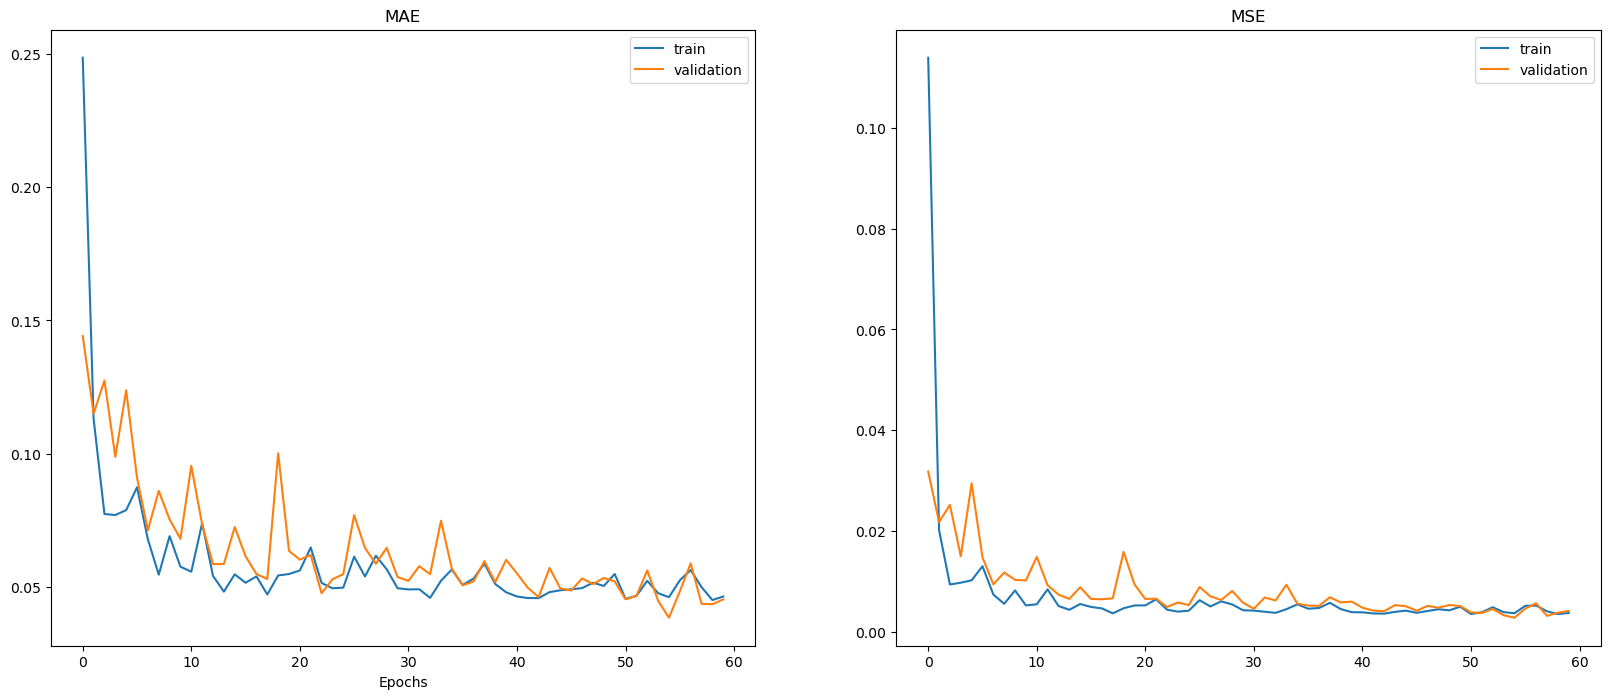

4/4 [==============================] - 0s 2ms/step
############################################
R^2 SCORE: 0.7998395530004235
PEARSONR: [0.9094753444607774]
MSE: 0.004725025966763496
MAE: 0.048396479338407516
############################################


############################################
ITERATION NR: 3
BATCH_SIZE: 6
OPTIMIZER LEARNING RATE: 0.01
############################################

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                256       
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
38/38 [===========================

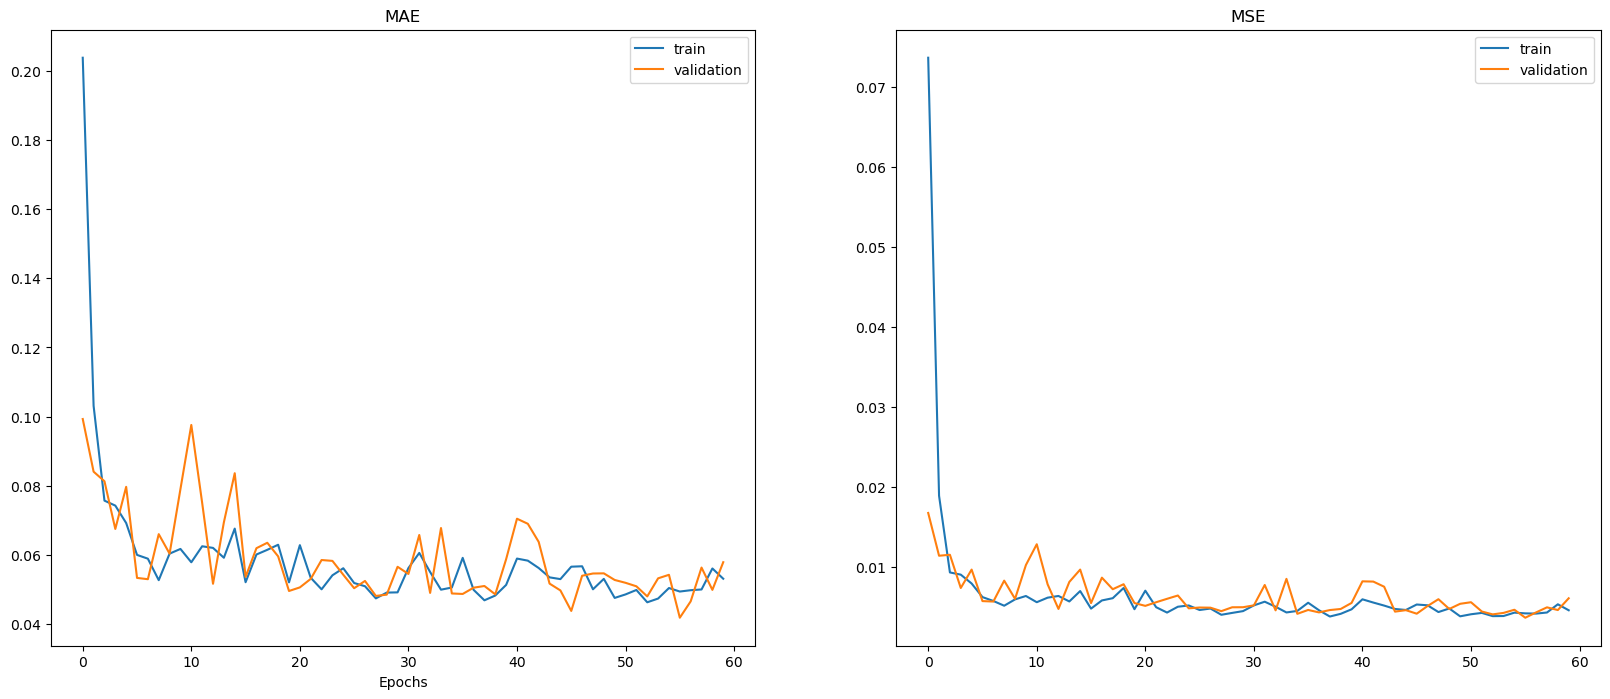

4/4 [==============================] - 0s 2ms/step
############################################
R^2 SCORE: 0.8201731555013921
PEARSONR: [0.912847322789927]
MSE: 0.0042450265027582645
MAE: 0.052345696836709976
############################################


############################################
ITERATION NR: 4
BATCH_SIZE: 8
OPTIMIZER LEARNING RATE: 0.01
############################################

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 32)                256       
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
29/29 [===========================

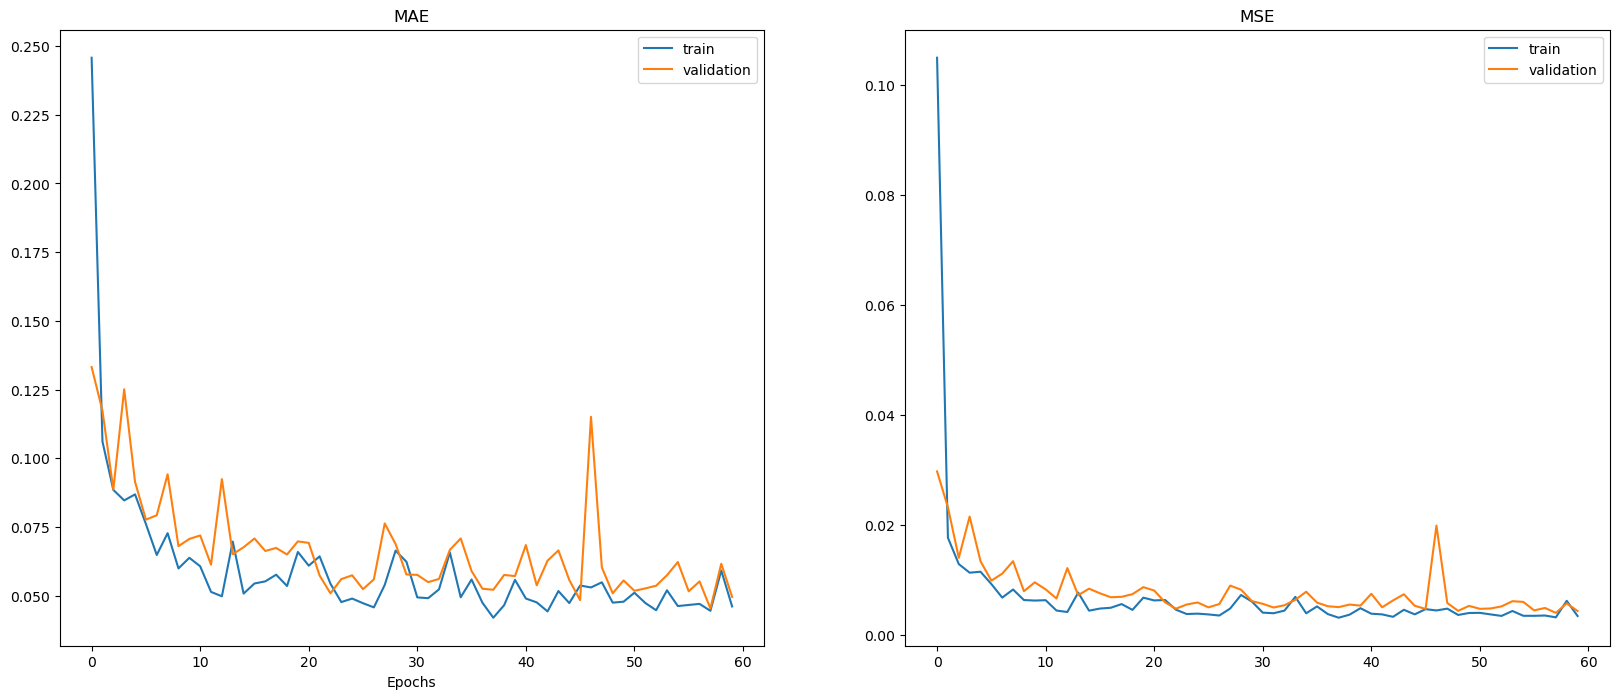

4/4 [==============================] - 0s 2ms/step
############################################
R^2 SCORE: 0.7926096099111847
PEARSONR: [0.8905610441352552]
MSE: 0.004895696882158518
MAE: 0.05451052635908127
############################################




In [19]:
scores = {}

for i in range(1, 5):
    print('############################################')
    print('ITERATION NR:', i)
    print('BATCH_SIZE:', i*2)
    print('OPTIMIZER LEARNING RATE:', 0.01)
    print('############################################\n')
    model, history, mmse, mmae = build_model(features_train_scale, features_test_scale, labels_train, labels_test, lr=0.01, batch_size=i*2)
    plot_history(history)
    predicted_values = model.predict(features_test_scale)
    
    r2_val = r2_score(labels_test, predicted_values)
    pear_val = pearsonr(labels_test, predicted_values)
    print('############################################')
    print('R^2 SCORE:', r2_val)
    print('PEARSONR:', pear_val[0])
    print('MSE:', mmse)
    print('MAE:', mmae)
    print('############################################\n\n')
    scores[i] = {
                 'BATCH_SIZE': str(i*2),   
                 'R2_SCORE':str(r2_val), 
                 'PEARSONR':str(pear_val[0]),
                 'MSE': str(mmse),
                 'MAE': str(mmae),
                }


In [20]:
for i in scores.keys():
    print(f'Scores iteration {i}:\n', scores[i], '\n\n')

Scores iteration 1:
 {'BATCH_SIZE': '2', 'R2_SCORE': '0.7970751939429527', 'PEARSONR': '[0.9010447171084132]', 'MSE': '0.004790281876921654', 'MAE': '0.0530892051756382'} 


Scores iteration 2:
 {'BATCH_SIZE': '4', 'R2_SCORE': '0.7998395530004235', 'PEARSONR': '[0.9094753444607774]', 'MSE': '0.004725025966763496', 'MAE': '0.048396479338407516'} 


Scores iteration 3:
 {'BATCH_SIZE': '6', 'R2_SCORE': '0.8201731555013921', 'PEARSONR': '[0.912847322789927]', 'MSE': '0.0042450265027582645', 'MAE': '0.052345696836709976'} 


Scores iteration 4:
 {'BATCH_SIZE': '8', 'R2_SCORE': '0.7926096099111847', 'PEARSONR': '[0.8905610441352552]', 'MSE': '0.004895696882158518', 'MAE': '0.05451052635908127'} 




After a long time of testing and tweaking the parameters I came up with best results so far. 
* Scores were slightly increasing with incrementing learning_rate, therefore I choose lr of 0.01. The smaller it was the worst the results.
* As we can se for each of tested batch sizes (2, 4, 6, 8) we have R^2 score around 0.8. That stands for well fitted model as it is close to 1. 
* Loss function (Mean Squared Error) denotes the measure of learning success and the lower the loss the better the performance. In this case value below 0.005 is quite satisfying
* Mean Absolute Error in case of regression tells us how far the predictions are on average from the true values. I have got best result in iteration nr.2 with batch_size=4 (less than 0.05).
